# Performance plots for reanalysed DR2 spectra

## Author(s): Sven Buder (SB, WG4)

### History:
180926 SB Created

In [24]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table
from scipy.io.idl import readsav
from scipy.stats import kde

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [25]:
data = pyfits.getdata('data/DR2_ts_rerun_matched.fits',1)

# Kiel diagrams DR2 vs. rerun

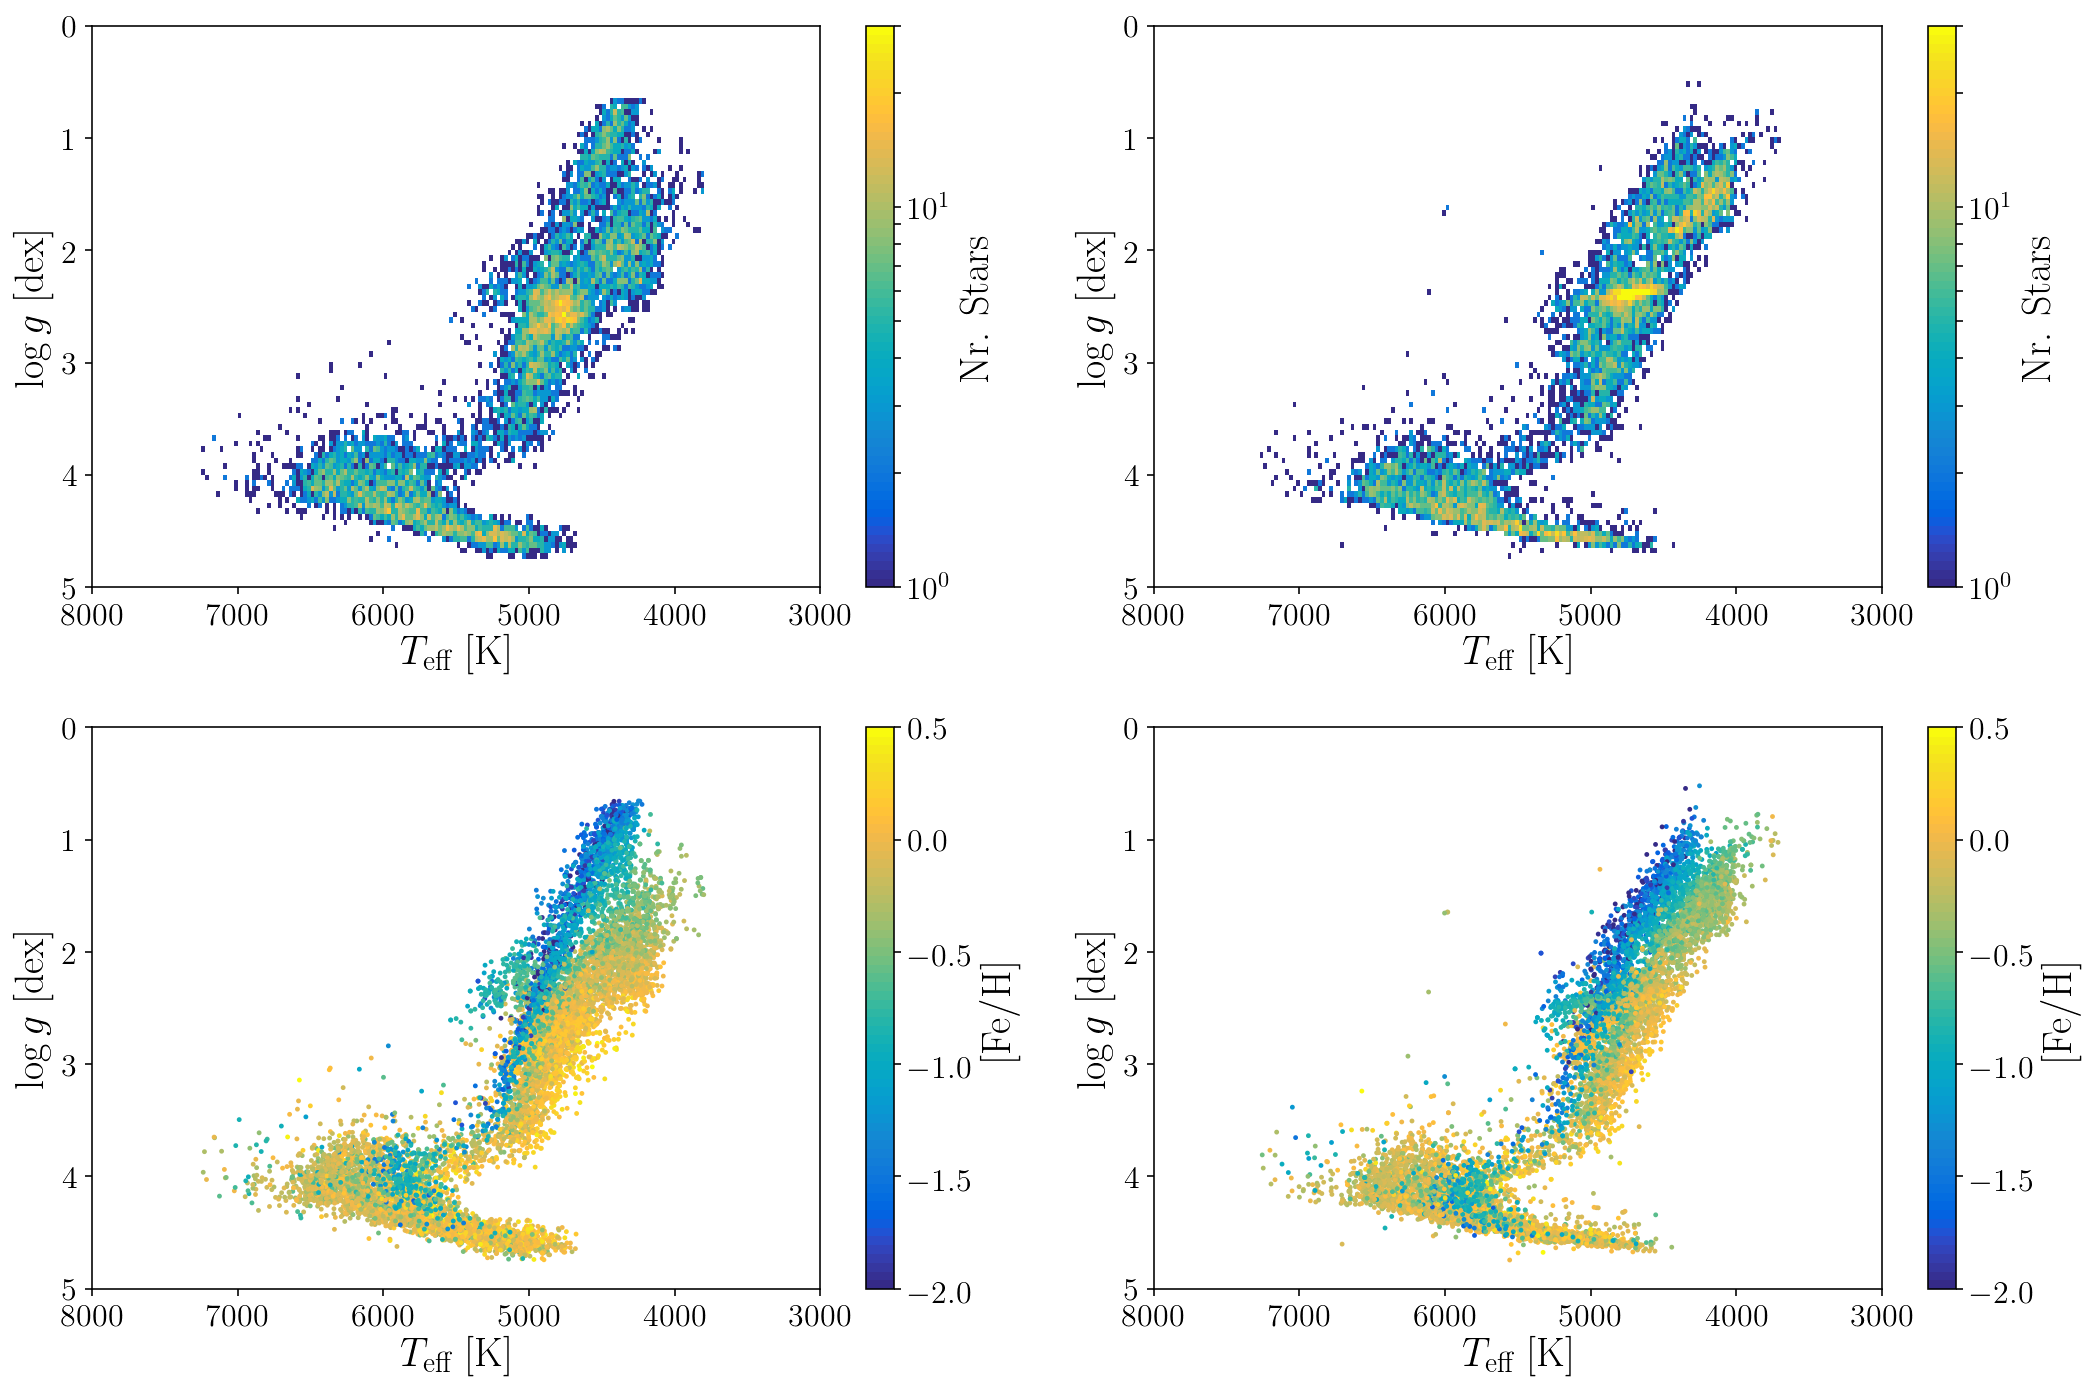

In [26]:
def plot_kiel():

    good_star = (
        (data['e_Teff_sme'] > 0) &
        np.isfinite(data['Feh_sme']) &
        (data['E_TEFF'] > 0) &
        np.isfinite(data['FEH'])
        )

    bins = (
        np.arange(3000, 8001, 25),
        np.arange(0.,5.01, 0.05)
    )

    kwargs_kiel = dict(
        cmap=parula,
        cmin=1,
        bins=bins,
        norm=LogNorm(),
        rasterized=True
    )

    kwargs_kiel_feh = dict(
        cmap=parula,
        vmin=-2.0,vmax=0.5,
        s=2,
        rasterized=True
    )

    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

    p1, x1, y1, s1 = ax1.hist2d(
        data['Teff_sme'][good_star],
        data['Logg_sme'][good_star],
        **kwargs_kiel
        )
    c1 = plt.colorbar(s1, ax=ax1)
    c1.set_label(r'Nr. Stars')

    p2, x2, y2, s2 = ax2.hist2d(
        data['TEFF'][good_star],
        data['LOGG'][good_star],
        **kwargs_kiel
        )
    c2 = plt.colorbar(s2, ax=ax2)
    c2.set_label(r'Nr. Stars')
    
    s3 = ax3.scatter(
        data['Teff_sme'][good_star],
        data['Logg_sme'][good_star],
        c=data['Feh_sme'][good_star],
        **kwargs_kiel_feh
    )
    c3 = plt.colorbar(s3, ax=ax3)
    c3.set_label(r'$\mathrm{[Fe/H]}$')

    s4 = ax4.scatter(
        data['TEFF'][good_star],
        data['LOGG'][good_star],
        c=data['FEH'][good_star],
        **kwargs_kiel_feh
    )
    c4 = plt.colorbar(s4, ax=ax4)
    c4.set_label(r'$\mathrm{[Fe/H]}$')

    ax1.set_xlabel(r'$T_\text{eff}$ [K]')
    ax1.set_ylabel(r'$\log g$ [dex]')
    ax2.set_xlabel(r'$T_\text{eff}$ [K]')
    ax2.set_ylabel(r'$\log g$ [dex]')
    ax3.set_xlabel(r'$T_\text{eff}$ [K]')
    ax3.set_ylabel(r'$\log g$ [dex]')
    ax4.set_xlabel(r'$T_\text{eff}$ [K]')
    ax4.set_ylabel(r'$\log g$ [dex]')

    ax1.set_xlim(8000,3000)
    ax1.set_ylim(5,0)
    ax2.set_xlim(8000,3000)
    ax2.set_ylim(5,0)
    ax3.set_xlim(8000,3000)
    ax3.set_ylim(5,0)
    ax4.set_xlim(8000,3000)
    ax4.set_ylim(5,0)

    plt.tight_layout()

plot_kiel();
plt.savefig('figures/dr2_rerun_kiel_comparison.pdf',dpi=300)

# Computational costs

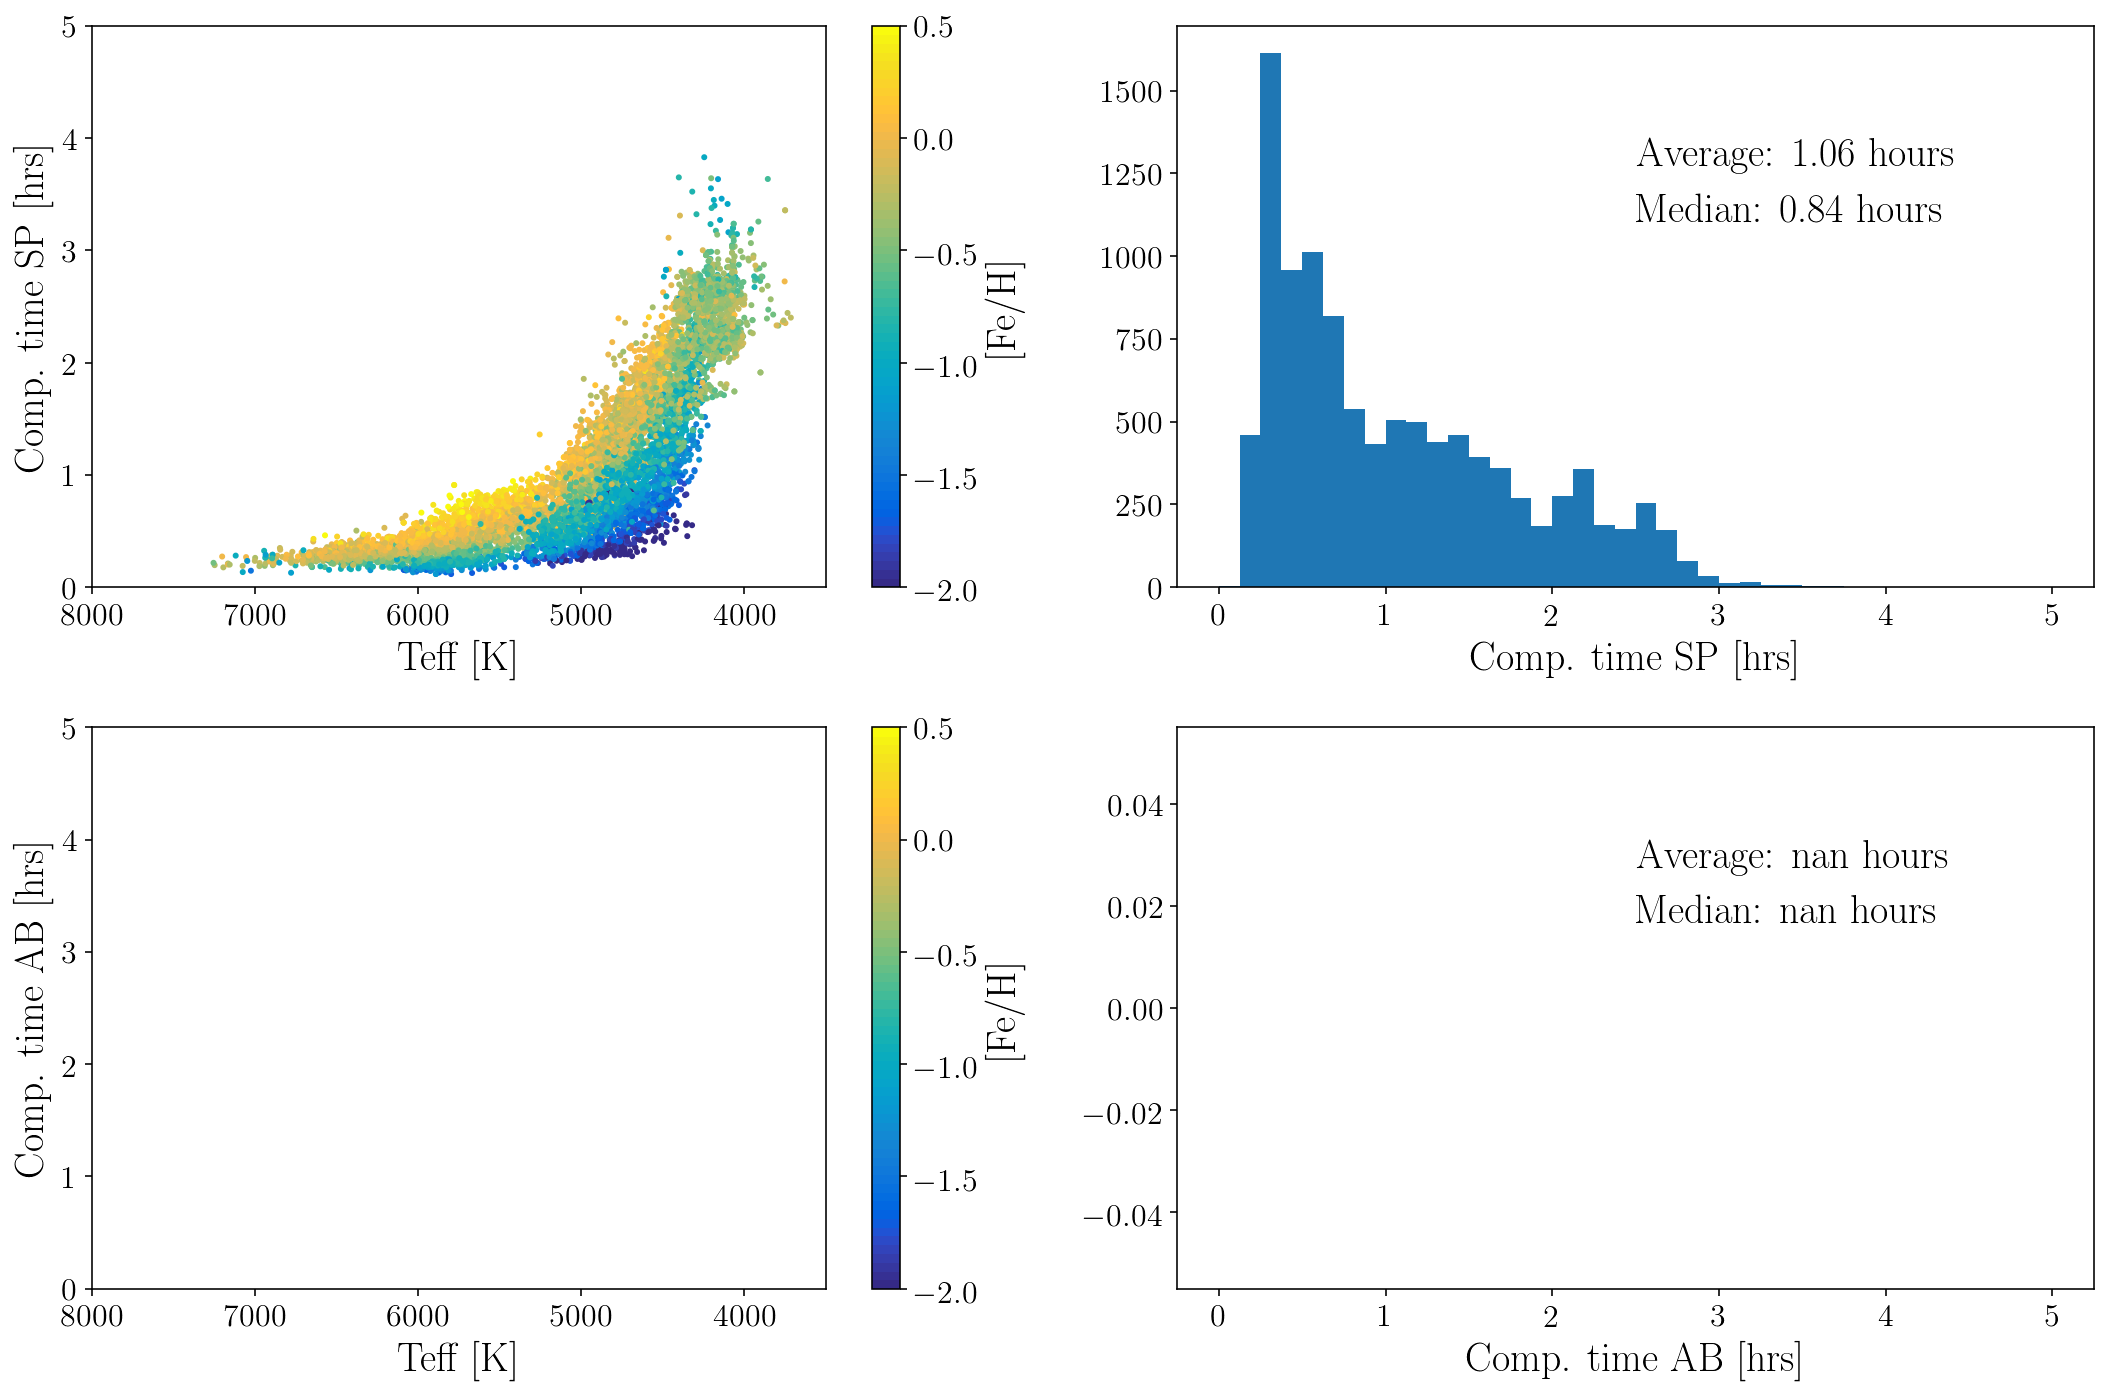

In [27]:
def plot_computational_costs():

    good_time = np.isfinite(data['TIME'][:,0])

    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
    s1 = ax1.scatter(
        data['TEFF'][good_time],
        data['TIME'][good_time,0] / 3600.,
        c = data['FEH'][good_time],
        s = 4, rasterized=True,
        vmin = -2.0, vmax = 0.5,
        cmap = parula)
    c1 = plt.colorbar(s1, ax=ax1)
    c1.set_label('[Fe/H]')
    ax1.set_xlim(8000,3500)
    ax1.set_xlabel('Teff [K]')
    ax1.set_ylim(0,5)
    ax1.set_ylabel('Comp. time SP [hrs]')

    ax2.hist(
        data['TIME'][good_time,0] / 3600.,
        bins=np.arange(0,5.1,0.125)
        )
    ax2.set_xlabel('Comp. time SP [hrs]')
    ax2.text(0.5,0.75,'Average: '+str('%.2f' % np.mean(data['TIME'][good_time,0] / 3600.))+' hours',transform=ax2.transAxes,fontsize=20)
    ax2.text(0.5,0.65,'Median: '+str('%.2f' % np.median(data['TIME'][good_time,0] / 3600.))+' hours',transform=ax2.transAxes,fontsize=20)

    ab_time = np.array([np.nansum(data['TIME'][x,1:])/ 3600. for x in range(len(data['TIME']))])
    good_time = (np.isfinite(ab_time) & (ab_time < 5) & (ab_time > 0))

    s3 = ax3.scatter(
        data['TEFF'][good_time],
        ab_time[good_time],
        c = data['FEH'][good_time],
        s = 4, rasterized=True,
        vmin = -2.0, vmax = 0.5,
        cmap = parula)
    c3 = plt.colorbar(s3, ax=ax3)
    c3.set_label('[Fe/H]')
    ax3.set_xlim(8000,3500)
    ax3.set_xlabel('Teff [K]')
    ax3.set_ylim(0,5)
    ax3.set_ylabel('Comp. time AB [hrs]')

    ax4.hist(
        ab_time[good_time],
        bins=np.arange(0,5.1,0.125)
        )
    ax4.set_xlabel('Comp. time AB [hrs]')
    ax4.text(0.5,0.75,'Average: '+str('%.2f' % np.mean(ab_time[good_time]))+' hours',transform=ax4.transAxes,fontsize=20)
    ax4.text(0.5,0.65,'Median: '+str('%.2f' % np.median(ab_time[good_time]))+' hours',transform=ax4.transAxes,fontsize=20)

    plt.tight_layout()
    plt.savefig('figures/computational_costs.png',dpi=300,bbox_inches='tight')
    plt.savefig('figures/computational_costs.pdf',dpi=300,bbox_inches='tight')

plot_computational_costs();

In [28]:
sun = pyfits.getdata('../abundance_zeropoints/galahdr3_abundance_zeropoints.fits',1)

In [30]:
def print_abundance_plots():

    with PdfPages('figures/ts_DR2_reran_abundances.pdf') as pdf:
        for each_elem in range(80):
            if each_elem > 0:

                element = data['MODE'][0,each_elem]

                if len(element) > 0:

                    detection = (data['AFLAG'][:,each_elem] == 0) & np.isfinite(data['A_ABUND'][:,each_elem]) & (data['AFLAG'][:,1] <= 1) & np.isfinite(data['A_ABUND'][:,1])
                    upper_limit = (data['AFLAG'][:,each_elem] == 1) & np.isfinite(data['A_ABUND'][:,each_elem]) & (data['AFLAG'][:,1] <= 1) & np.isfinite(data['A_ABUND'][:,1])

                    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

                    kwargs_detection = dict(
                        cmin=1, cmap=parula, rasterized=True)

                    p1,x1,y1,s1 = ax1.hist2d(
                        data['A_ABUND'][detection,1] - sun['A_Fe'][0],
                        data['A_ABUND'][detection,each_elem] - sun['A_'+element][0] - (data['A_ABUND'][detection,1] - sun['A_Fe'][0]),
                        bins=(
                            np.arange(-4,0.75,0.05),
                            50#np.arange(-1,1,0.025)
                        ),
                        **kwargs_detection
                    )
                    ax1.set_xlabel(r'$\mathrm{[Fe/H]}$')
                    ax1.set_ylabel('['+element+'/Fe]')

                    p2,x2,y2,s2 = ax2.hist2d(
                        data['FEH'][detection],
                        data['A_ABUND'][detection,each_elem] - sun['A_'+element][0] - data['FEH'][detection],
                        bins=(
                            np.arange(-4,0.75,0.05),
                            50#np.arange(-1,1,0.025)
                        ),
                        **kwargs_detection
                    )
                    ax2.set_xlabel(r'$\mathrm{[Fe/H]_\text{atmo}}$')
                    ax2.set_ylabel(r'['+element+r'/$\mathrm{Fe_\text{atmo}]}$')


                    p3,x3,y3,s3 = ax3.hist2d(
                        data['A_ABUND'][detection,1] - sun['A_Fe'][0],
                        data['A_ABUND'][detection,each_elem],
                        bins=(
                            np.arange(-4,0.75,0.05),
                            50#np.arange(-1,1,0.025)
                        ),
                        **kwargs_detection
                    )
                    ax3.set_xlabel(r'$\mathrm{[Fe/H]}$')
                    ax3.set_ylabel(r'A('+element+')')

                    c1 = plt.colorbar(s1, ax=ax1)
                    c2 = plt.colorbar(s2, ax=ax2)
                    c3 = plt.colorbar(s3, ax=ax3)
                    c1.set_label('Nr. Stars')
                    c2.set_label('Nr. Stars')
                    c3.set_label('Nr. Stars')

                    plt.tight_layout()
                    pdf.savefig(f, dpi=300)

print_abundance_plots();

IndexError: too many indices for array